In [1]:
from gridworld import GridworldEnv
from Algorithms.single_q_learning import SingleQLearning
from Algorithms.double_q_learning import DoubleQLearning

from typing import List
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import csv
import gym
from gym import spaces
import time
from tqdm import tqdm

C:\Users\aukee\miniconda3\envs\rl-project\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

List all games

For each game, run double q and single q, over 10 random seeds and save results
Metrics are:
episode returns (/time)
episode lengths (/time) ?


In [3]:
def experiment(env_names, params: dict, seeds : List[int], default_dir='Results'):
    
    for env_name in env_names:
        print("Starting experiment for", env_name)
        env = gym.make(env_name)
        
        # Get results for test
        single_results, double_results = run_experiment(env, policy=None, seeds=seeds, params=params)

        # Save Results to csv
        str_params = ''
        if not params is None:
            for key, value in params.items():
                str_params += key + '=' + str(value) + '_'
        save_dir = os.path.join(default_dir, env_name, str_params)
        save_results(single_results, double_results, save_dir=save_dir)

        # Plot results
        plot_results(single_results, double_results, save_dir=save_dir)

        #Close environment to prevent issues
        env.close()
        print("\n\n")
    
    return


In [4]:
def run_experiment(env, policy=None, seeds : List[int] = None, params : dict = None, show_episodes=False):
   
    # If no seeds are provided, simply take the indices of the runs
    if seeds is None:
        seeds = [i for i in range(10)]

    # Obtain results for each random seed
    single_lengths = []
    single_returns = []
    double_lengths = []
    double_returns = []
    
    for i in tqdm(seeds):
        np.random.seed(i)
        single_result, double_result = single_run(env, policy=policy, params=params, show_episodes=show_episodes)
        single_lengths.append(single_result[0])
        single_returns.append(single_result[1])
        double_lengths.append(double_result[0])
        double_returns.append(double_result[1])
        

    return (single_lengths, single_returns), (double_lengths, double_returns)


In [5]:
def process_results(results):
    lengths = np.array(results[0])
    mean_lengths, std_lengths = get_stats(lengths)
    
    returns = np.array(results[1])
    mean_returns, std_returns = get_stats(returns)

    return (mean_lengths, std_lengths), (mean_returns, std_returns)


def get_stats(data):
    data = np.array(data)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return mean, std


def save_results(single_results, double_results, save_dir='Results'):
    os.makedirs(save_dir, exist_ok=True)
    write_result(single_results[0], 'Single Lengths', save_dir=save_dir)
    write_result(single_results[1], 'Single Returns', save_dir=save_dir)
    write_result(double_results[0], 'Double Lengths', save_dir=save_dir)
    write_result(double_results[1], 'Double Returns', save_dir=save_dir)
    return


def write_result(results, header, save_dir='Results', file_id=''):
    file_name = header + file_id + '.csv'
    file_path = os.path.join(save_dir, file_name)

    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        header = [header] + [i for i in range(len(results[0]))]
        writer.writerow(header)

        for j in range(len(results)):
            row = [j] + list(results[j])
            writer.writerow(row)
        mean, std = get_stats(results)
        mean_row = ['Mean'] + mean.tolist()
        std_row = ['Std. Dev.'] + std.tolist()
        writer.writerow(mean_row)
        writer.writerow(std_row)
    return


In [6]:
def single_run(env, policy=None, params : dict = None, show_episodes=False):
    if params is None:
        params = {}

    epsilon = params.setdefault('epsilon', 0.1)
    num_episodes = params.setdefault('num_episodes', 1000)
    discount_factor = params.setdefault('discount_factor', 1)
    alpha = params.setdefault('alpha', 0.1)
    
    # For a single run, obtain all metrics and return
    single_q_vals, single_q_results = single_q(env, policy=policy, epsilon=epsilon, num_episodes=num_episodes, \
        discount_factor=discount_factor, alpha=alpha, show_episodes=show_episodes)
    double_q_vals, double_q_results = double_q(env, policy=policy, epsilon=epsilon, num_episodes=num_episodes, \
        discount_factor=discount_factor, alpha=alpha, show_episodes=show_episodes)
    return (single_q_results, double_q_results)

        
def single_q(env, policy=None, epsilon=0.1, num_episodes=1000, discount_factor=1, alpha=0.1, show_episodes=False):
        
    if policy is None:
        Q = {}
        policy = SingleQLearning.EpsilonGreedyPolicy(Q, epsilon=epsilon)

    Q_values, (episode_lengths, episode_returns) = \
        SingleQLearning.single_q_learning(env, policy, num_episodes, Q=None,\
            discount_factor=discount_factor, alpha=alpha, show_episodes=show_episodes)
    return Q_values, (episode_lengths, episode_returns)
    

def double_q(env, policy=None, epsilon=0.1, num_episodes=1000, discount_factor=1, alpha=0.1, show_episodes=False):

    if policy is None:
        Q_a = {}
        Q_b = {}
        policy = DoubleQLearning.EpsilonGreedyPolicy(Q_a, Q_b, epsilon=epsilon)

    Q_values, (episode_lengths, episode_returns) = \
        DoubleQLearning.double_q_learning(env, policy, num_episodes, Q_a=None, Q_b=None,\
            discount_factor=discount_factor, alpha=alpha, show_episodes=show_episodes)
    return  Q_values, (episode_lengths, episode_returns)


In [7]:
def get_Q_dims(env):
    try:
        Q = np.zeros((env.nS, env.nA))

    except AttributeError:
        num_states = get_dims(env.observation_space)
        num_actions = get_dims(env.action_space)
        Q = np.zeros((*num_states, *num_actions))

    return Q

def get_dims(space):
    if isinstance(space, spaces.Tuple):
        n_dims = []
        for subspace in space:
            n_dims += (get_dims(subspace))

    elif isinstance(space, spaces.Discrete):
        n_dims = [space.n]

    else:
        raise TypeError("Space not Discrete.")

    return n_dims

plot metrics and save figures

In [8]:
def plot_results(single_results, double_results, save_dir=None, file_id='', file_type='.png', show=False):
    # A comparison of double_Q vs single_Q over all runs
    # A comparison of the first half of single against itself and double against itself
    # A comparison of the first half of double and single vs the second half

    (mean_single_lengths, std_single_lengths), (mean_single_returns, std_single_returns) = process_results(single_results)
    (mean_double_lengths, std_double_lengths), (mean_double_returns, std_double_returns) = process_results(double_results)

    # So 3x2 plots
    fig = plt.figure(figsize=(20, 5))
    # fig.suptitle("Results")

    # plt.text("Episode Returns")
    # plt.text("Episode Lengths")
    # A comparison of episode returns for single_Q vs double_Q over all runs
    fig.add_subplot(121)
    plot_metric("Episode Returns", mean_single_returns, std_single_returns, mean_double_returns, std_double_returns)

    # A Comparison of episode lengths for single_Q vs double_Q over all runs
    fig.add_subplot(122)
    plot_metric("Episode Lengths", mean_single_lengths, std_single_lengths, mean_double_lengths, std_double_lengths)

 

    # # A comparison of the episode returns for different random seeds for single Q 
    # fig.add_subplot(323)
    # plot_metric(single_q_returns[:half], single_q_returns[half:])

    # # A comparison of the episode lengths for different random seeds for single Q
    # fig.add_subplot(324)
    # plot_metric(single_q_lengths[:half], single_q_lengths[half:])

    # # A comparison of the episode returns for different random seeds for double Q 
    # fig.add_subplot(325)
    # plot_metric(double_q_returns[:half], double_q_returns[half:])

    # # A comparison of the episode lengths for different random seeds for double Q 
    # fig.add_subplot(326)
    # plot_metric(double_q_lengths[:half], double_q_lengths[half:])
    
    if save_dir:
        file_path = save_dir + file_type
        plt.savefig(file_path)
    
    plt.show()
    
    return


def plot_metric(title, single_mean, single_std, double_mean, double_std, save_dir=None, file_type='.png', save=False, show=False):

    plt.plot(single_mean)
    plt.fill_between(range(len(single_mean)), single_mean - single_std, single_mean + single_std, alpha=0.3)
    plt.plot(double_mean)
    plt.fill_between(range(len(single_mean)), double_mean - double_std, double_mean + double_std, alpha=0.3)
    plt.title(title)
    plt.legend(['Single Q-Learning', "Double Q-learning"])

    if save_dir:
        filename = title + file_type
        file_path = os.path.join(save_dir, filename)
        plt.savefig(file_path)

    if show:
        plt.show()

    return

The cell below runs a full experiment on all the easy toy_text examples from the openAI gym.
All results are saved to csv, with the mean and std_dev at each episode included.
Plots are also saved to the same folder.

Starting experiment for CliffWalking-v0


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


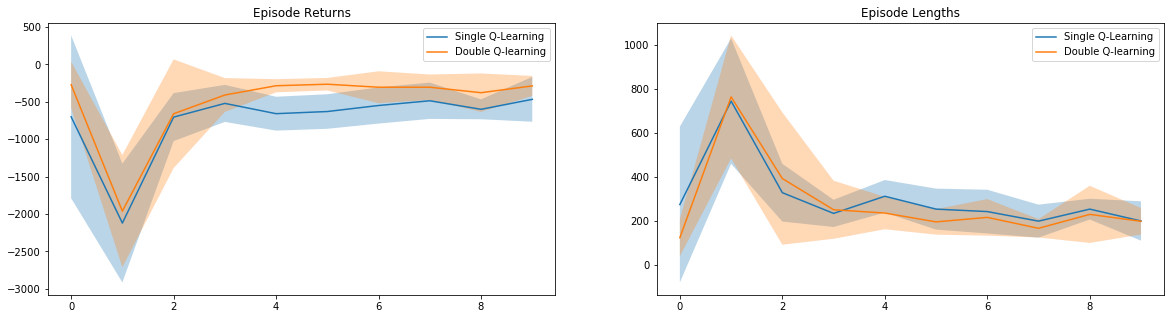




Starting experiment for Blackjack-v1


100%|██████████| 10/10 [00:00<00:00, 281.53it/s]


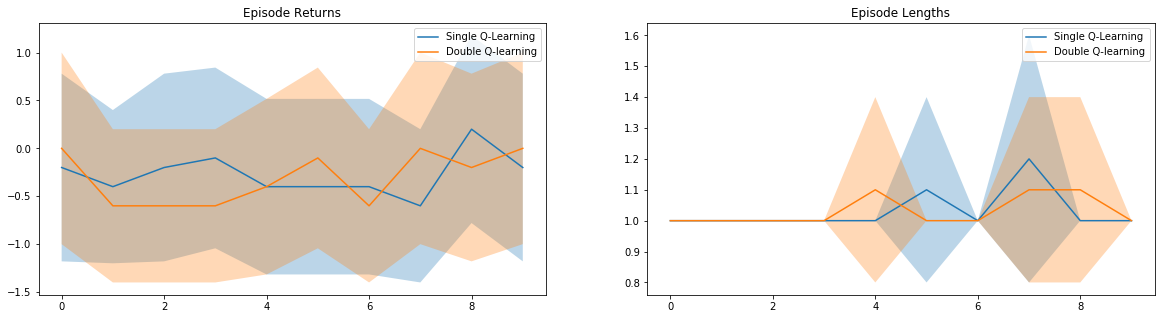




Starting experiment for FrozenLake-v1


100%|██████████| 10/10 [00:00<00:00, 65.74it/s]


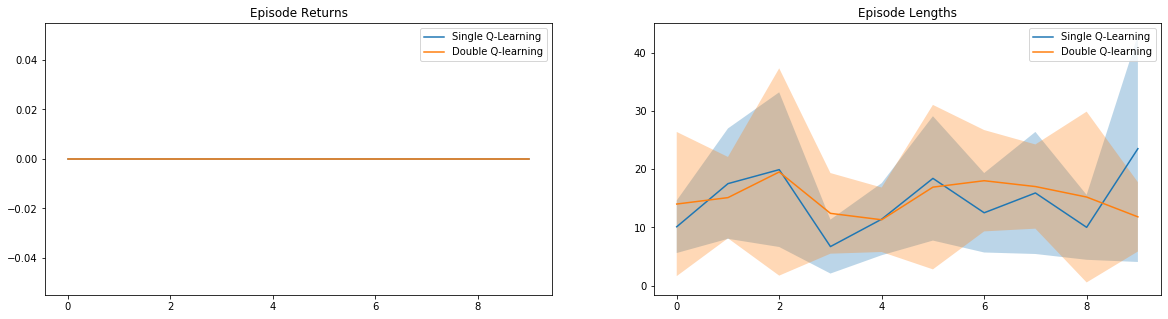




Starting experiment for FrozenLake8x8-v1


100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


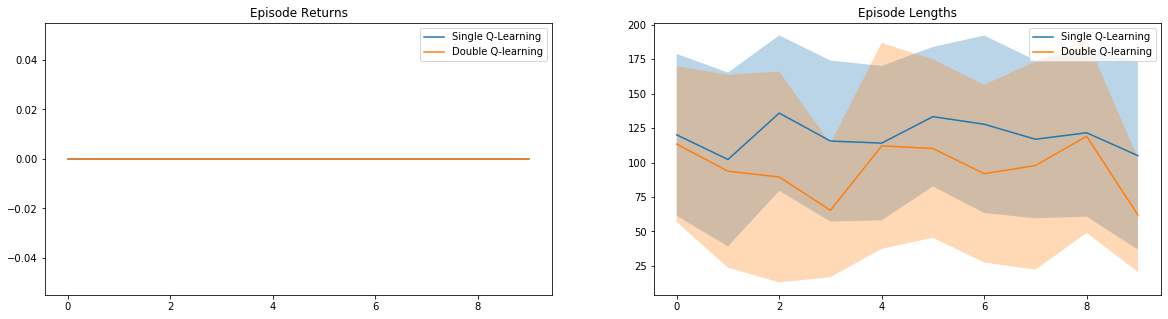




Starting experiment for Taxi-v3


100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


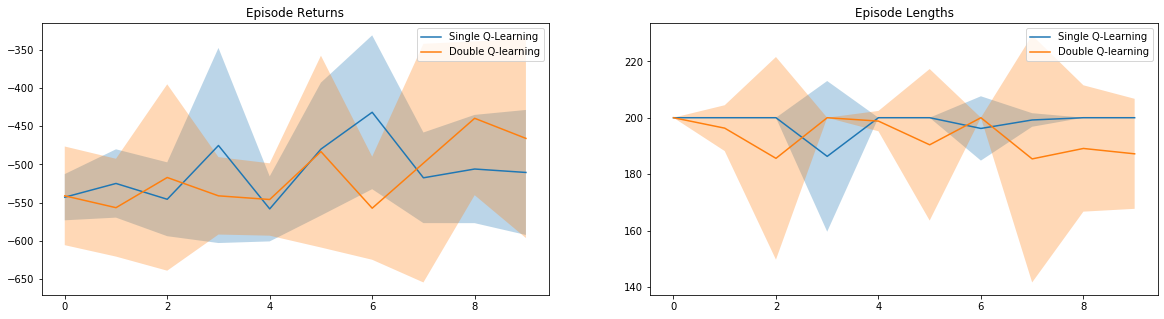

In [9]:
toy_seeds = None #Defaults to [0-9]

toy_params = {
'epsilon': 0.1, #Defaults to  0.1
'num_episodes': 10, #Defaults to 1000
'discount_factor': 1.0, #Defaults to 1.0
'alpha': 0.1 #Defaults to 0.1
}

toy_text = ['CliffWalking-v0', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'Taxi-v3']

experiment(toy_text, toy_params, toy_seeds)


Quick setup for a gridsearch if we want to do one

In [10]:
epsilons = [0.1, 0.05, 0.01]
num_episodeses = [1000] # I guess you just make this higher, no need to grid search
discount_factors = [0.7, 0.85, 1.0]
alphas = [0.1, 0.05, 0.01]

def grid_search(env_names, epsilons, num_episodeses, discount_factors, alphas, seeds=None, default_dir='Results'):
    params = {}
    for epsilon in epsilons:
        params['epsilon'] = epsilon
        for num_episodes in num_episodeses:
            params['num_episodes'] = num_episodes
            for discount_factor in discount_factors:
                params['discount_factor'] = discount_factor
                for alpha in alphas:
                    params['alpha'] = alpha
                    experiment(env_names, params, seeds=seeds, default_dir=default_dir)
                    


The continuous control tasks are not yet implemented, the discretization is not finished

In [11]:
control_seeds = None #Defaults to [0-9]

control_params = {
'epsilon': 0.1, #Defaults to 0.1
'num_episodes': 10, #Defaults to 1000
'discount_factor':1.0, #Defaults to 1.0
'alpha': 0.1 #Defaults to 0.1
}

continuous_control = ['Acrobot-v1', 'CartPole-v1', 'Pendulum-v1', 'MountainCar-v0', 'MountainCarContinuous-v0']



In [12]:
def get_num_actions(env):
    from gym.envs.toy_text.discrete import DiscreteEnv  
    from gym import spaces

    if isinstance(env, DiscreteEnv):
        num_actions = env.nA

    elif isinstance(env.action_space, spaces.Discrete):
        num_actions = env.action_space.n

    elif isinstance(env.action_space, spaces.Box):
        num_actions = -1

    return num_actions


def discretize_space(space : spaces.Box, intervals=20):
    low = space.low
    high = space.high



In [13]:
# experiment(continuous_control, control_seeds, control_params)

FROZEN LAKE

Winter is here. You and your friends were tossing around a frisbee at the
park when you made a wild throw that left the frisbee out in the middle of
the lake. The water is mostly frozen, but there are a few holes where the
ice has melted. If you step into one of those holes, you'll fall into the
freezing water. At this time, there's an international frisbee shortage, so
it's absolutely imperative that you navigate across the lake and retrieve
the disc. However, the ice is slippery, so you won't always move in the
direction you intend.
The surface is described using a grid like the following
    SFFF
    FHFH
    FFFH
    HFFG
S : starting point, safe
F : frozen surface, safe
H : hole, fall to your doom
G : goal, where the frisbee is located
The episode ends when you reach the goal or fall in a hole.
You receive a reward of 1 if you reach the goal, and zero otherwise.

The basic grid is 4x4, the larger version is 8x8.
"""

CLIFFWORLD

This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.
    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf
    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py
    The board is a 4x12 matrix, with (using NumPy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    """



SIMPLE BLACKJACK ENVIRONMENT

Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.
Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).
The game starts with dealer having one face up and one face down card, while
player having two face up cards. (Virtually for all Blackjack games today).
The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).
After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.  The reward for winning is +1,
drawing is 0, and losing is -1.
The observation of a 3-tuple of: the players current sum,
the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).
This environment corresponds to the version of the blackjack problem
described in Example 5.1 in Reinforcement Learning: An Introduction
by Sutton and Barto.
http://incompleteideas.net/book/the-book-2nd.html
"""

  THE TAXI PROBLEM

from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
by Tom Dietterich
Description:
There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
Observations:
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.
Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode.
Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination.
This gives a total of 404 reachable discrete states.
Passenger locations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi
Destinations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
Actions:
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger


Rewards:
There is a default per-step reward of -1,
except for delivering the passenger, which is +20,
or executing "pickup" and "drop-off" actions illegally, which is -10.
Rendering:
- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters (R, G, Y and B): locations for passengers and destinations
state space is represented by:
    (taxi_row, taxi_col, passenger_location, destination)
"""

To find all envs, just use 

In [14]:
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(ALE/Tetris-v5), EnvSpec(ALE/Tetris-ram-v5), EnvSpec(Adventure-v0), EnvSpec(AdventureDeterministic-v0), EnvSpec(AdventureNoFrameskip-v0), EnvSpec(Adventure-v4), EnvSpec(AdventureDeterministic-v4), EnvSpec(AdventureNoFrameskip-v4), EnvSpec(Adventure-ram-v0), EnvSpec(Adventure-ramDeterministic-v0), EnvSpec(Adventure-ramNoFrameskip-v0), EnvSpec(Adventure-ram-v4), EnvSpec(Adventure-ramDeterministic-v4), EnvSpec(Adventure-ramNoFrameskip-v4), EnvSpec(AirRaid-v0), EnvSpec(AirRaidDeterministic-v0), EnvSpec(AirRaidNoFrameskip-v0), EnvSpec(AirRaid-v4), EnvSpec(AirRaidDeterministic-v4), EnvSpec(AirRaidNoFrameskip-v4), EnvSpec(AirRaid-ram-v0), EnvSpec(AirRaid-ramDeterministic-v0), EnvSpec(AirRaid-ramNoFrameskip-v0), EnvSpec(AirRaid-ram-v4), EnvSpec(AirRaid-ramDeterministic-v4), EnvSpec(AirRaid-ramNoFrameskip-v4), EnvSpec(Alien-v0), EnvSpec(AlienDeterministic-v0), EnvSpec(AlienNoFrameskip-v0), EnvSpec(Alien-v4), EnvSpec(AlienDeterministic-v4), EnvSpec(AlienNoFrameskip-v4), EnvSp